- train.csv: training set
- test.csv: test set
- sample_submission.csv: sample submission
- Features
- id: only for test & sample submission files, id for prediction sample identification
- price: price in USD
- carat: weight of the diamond
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour
- clarity: a measurement of how clear the diamond is
- x: length in mm
- y: width in mm
- z: depth in mm
- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: width of top of diamond relative to widest point (43--95)

In [1]:
import pandas as pd
import numpy as np
import sidetable
import src as sp
from scipy import stats
import math
import pickle

#librerias limpieza de nulos
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

#Normalizacion
from sklearn.preprocessing import MinMaxScaler


#Estandarización
## esto es un metodo que estandariza automaticamente todas las columnas del dataframe que le pasemos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#Normalizacion
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder



#libreria para el balanceo
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# librerías para crear el modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from xgboost import XGBRegressor
from  sklearn.ensemble import GradientBoostingRegressor


# para calcular las métricas regresion logistica
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/train.csv")
df.drop("id", axis =1, inplace= True)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [3]:
df_num = df.select_dtypes(include= np.number)
df_num.drop("price",axis= 1, inplace= True)

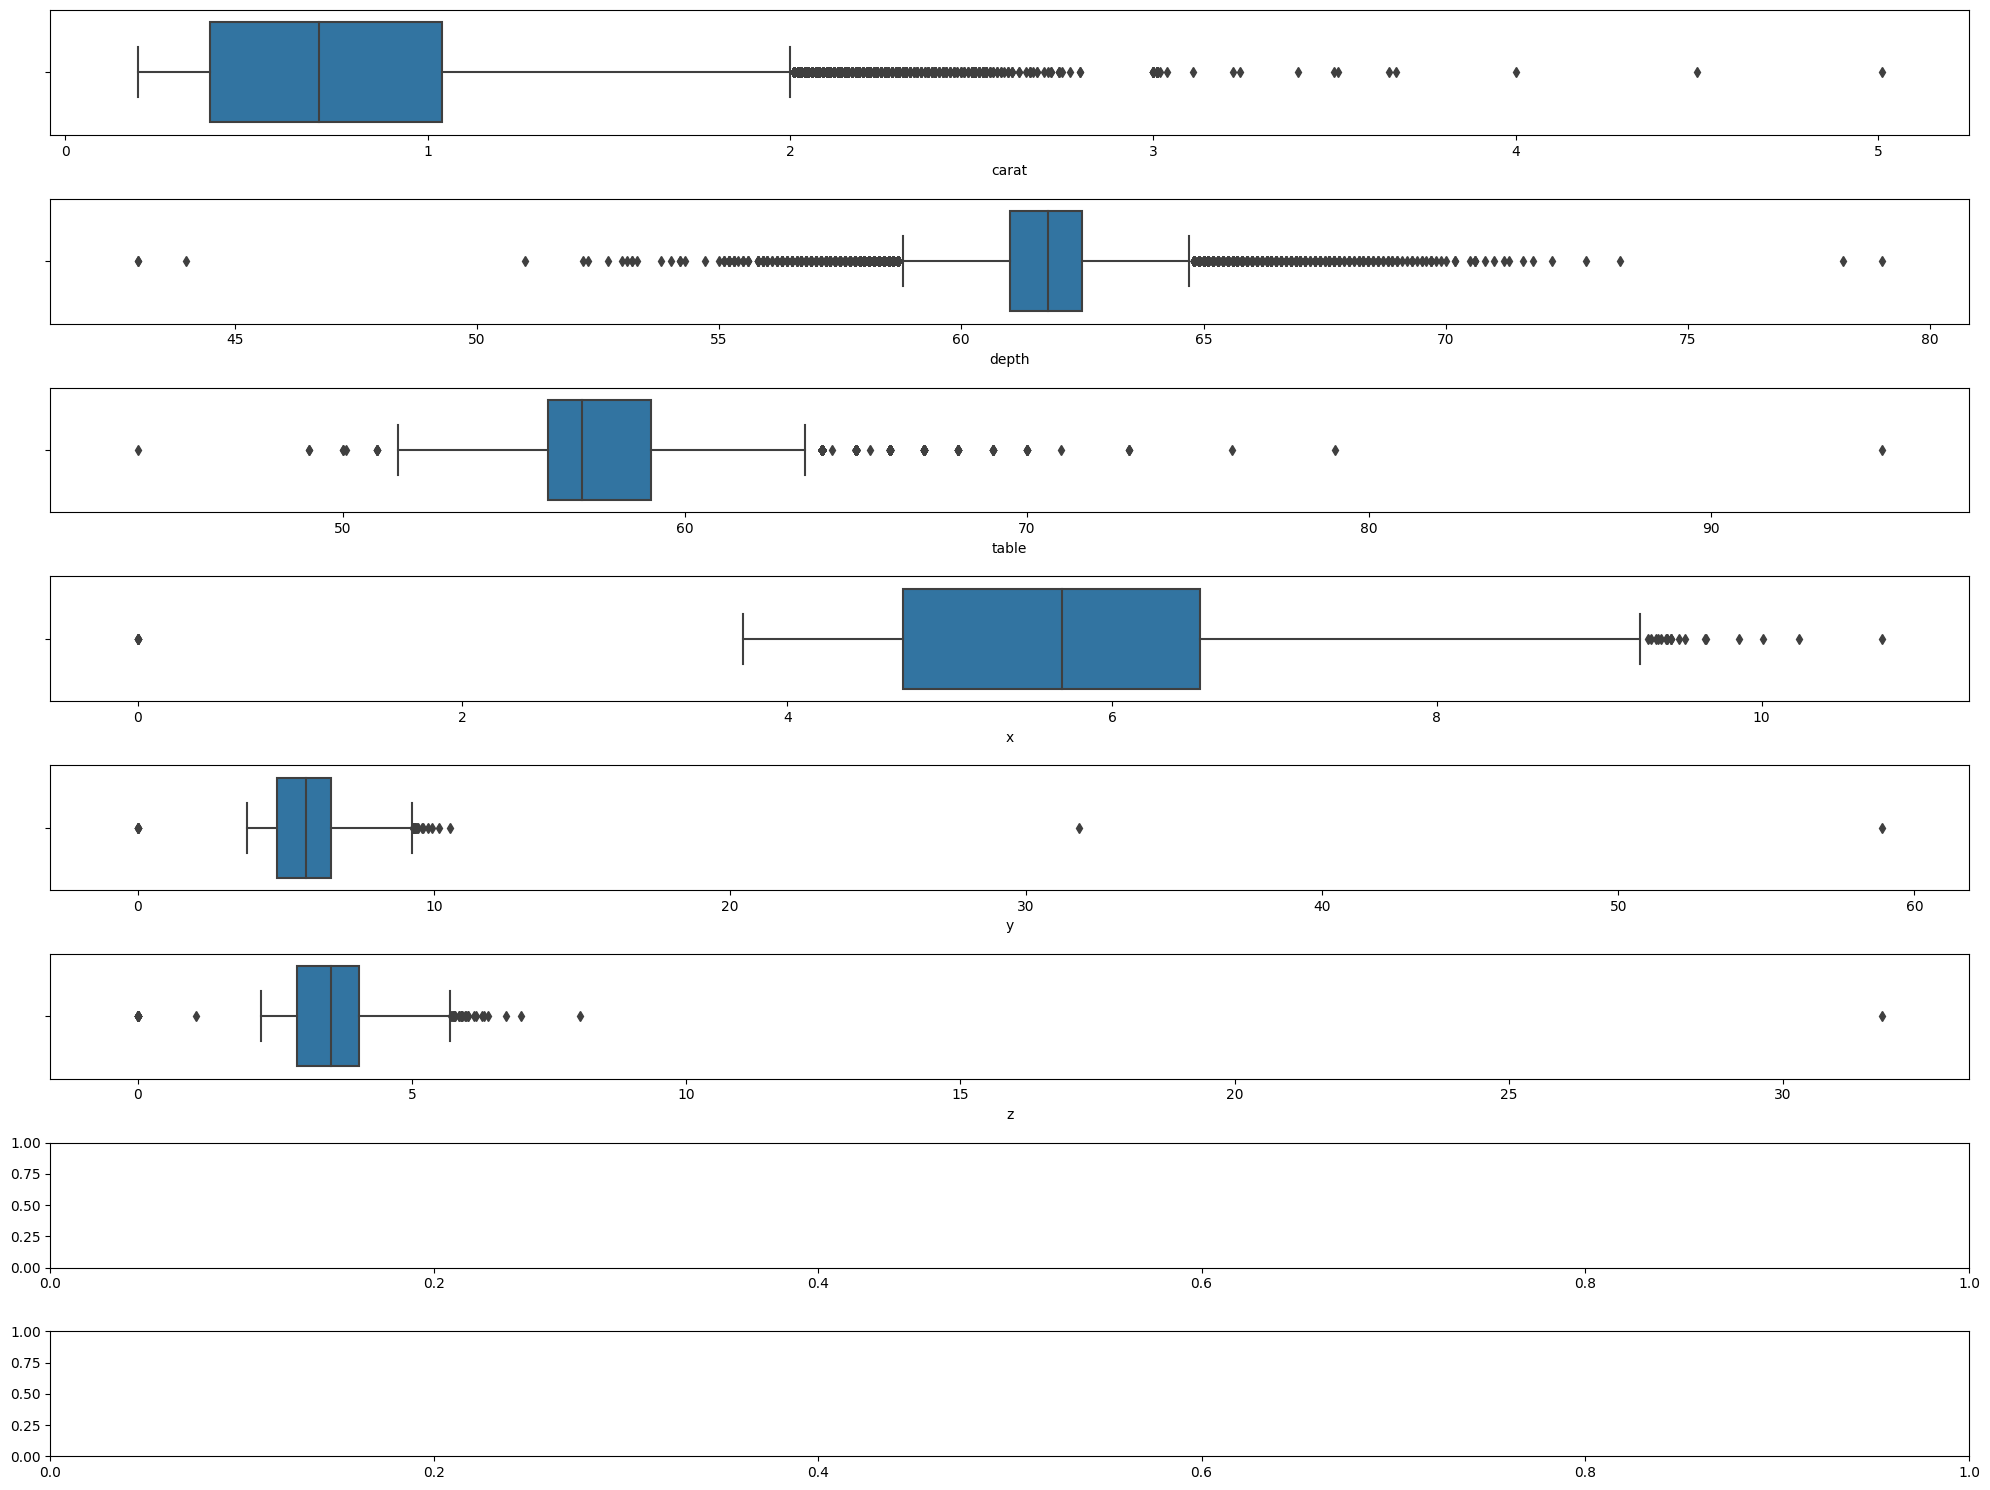

In [4]:
fig, axes = plt.subplots(nrows= 8,ncols= 1, figsize=(20,15))

for i , columna in enumerate(df_num.columns):
    
    sns.boxplot(data = df_num,
                x = columna,
                ax = axes[i])
    plt.tight_layout()

### se tratan los valores = 0. Suelen ser errores al transformar datos, asique se sustiuira por la media.

In [5]:
df[df["z"]== 0]

,carat,cut,color,clarity,depth,table,x,y,z,price
1249,2.25,Premium,I,SI1,61.3,58.0,8.52,8.42,0.0,9.642
3185,1.20,Premium,D,VVS1,62.1,59.0,0.00,0.00,0.0,9.661
4057,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0,7.664
4401,1.10,Premium,G,SI2,63.0,59.0,6.50,6.47,0.0,8.215
7910,1.00,Very Good,H,VS2,63.3,53.0,0.00,0.00,0.0,8.545
8174,1.01,Premium,F,SI2,59.2,58.0,6.50,6.47,0.0,8.252
8820,2.25,Premium,H,SI2,62.8,59.0,0.00,0.00,0.0,9.800
10669,1.50,Good,G,I1,64.0,61.0,7.15,7.04,0.0,8.462
10881,1.01,Premium,H,I1,58.1,59.0,6.66,6.60,0.0,8.061
12992,2.02,Premium,H,VS2,62.7,53.0,8.02,7.95,0.0,9.810


In [6]:
lista_0 = df[df["z"]== 0].index.to_list
lista_0

<bound method IndexOpsMixin.tolist of Int64Index([ 1249,  3185,  4057,  4401,  7910,  8174,  8820, 10669, 10881,
            12992, 13711, 19007, 23431, 26686, 30214, 31910, 34815],
           dtype='int64')>

In [7]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [8]:
ind =detectar_outliers(df_num.columns,df)

In [9]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
carat,40455.0,0.797576,0.475939,0.200,0.400,0.70,1.040,5.010
depth,40455.0,61.746377,1.436796,43.000,61.000,61.80,62.500,79.000
table,40455.0,57.451694,2.234569,44.000,56.000,57.00,59.000,95.000
x,40455.0,5.729163,1.125244,0.000,4.710,5.69,6.540,10.740
y,40455.0,5.732896,1.154799,0.000,4.720,5.70,6.540,58.900
z,40455.0,3.537351,0.711002,0.000,2.910,3.52,4.030,31.800
price,40455.0,7.783822,1.016828,5.787,6.851,7.78,8.581,9.842


In [10]:
for key, value in ind.items():
    for i in value:
        valor_mean = df.describe().T.loc[key,"mean"]
        df.loc[i, key] = valor_mean



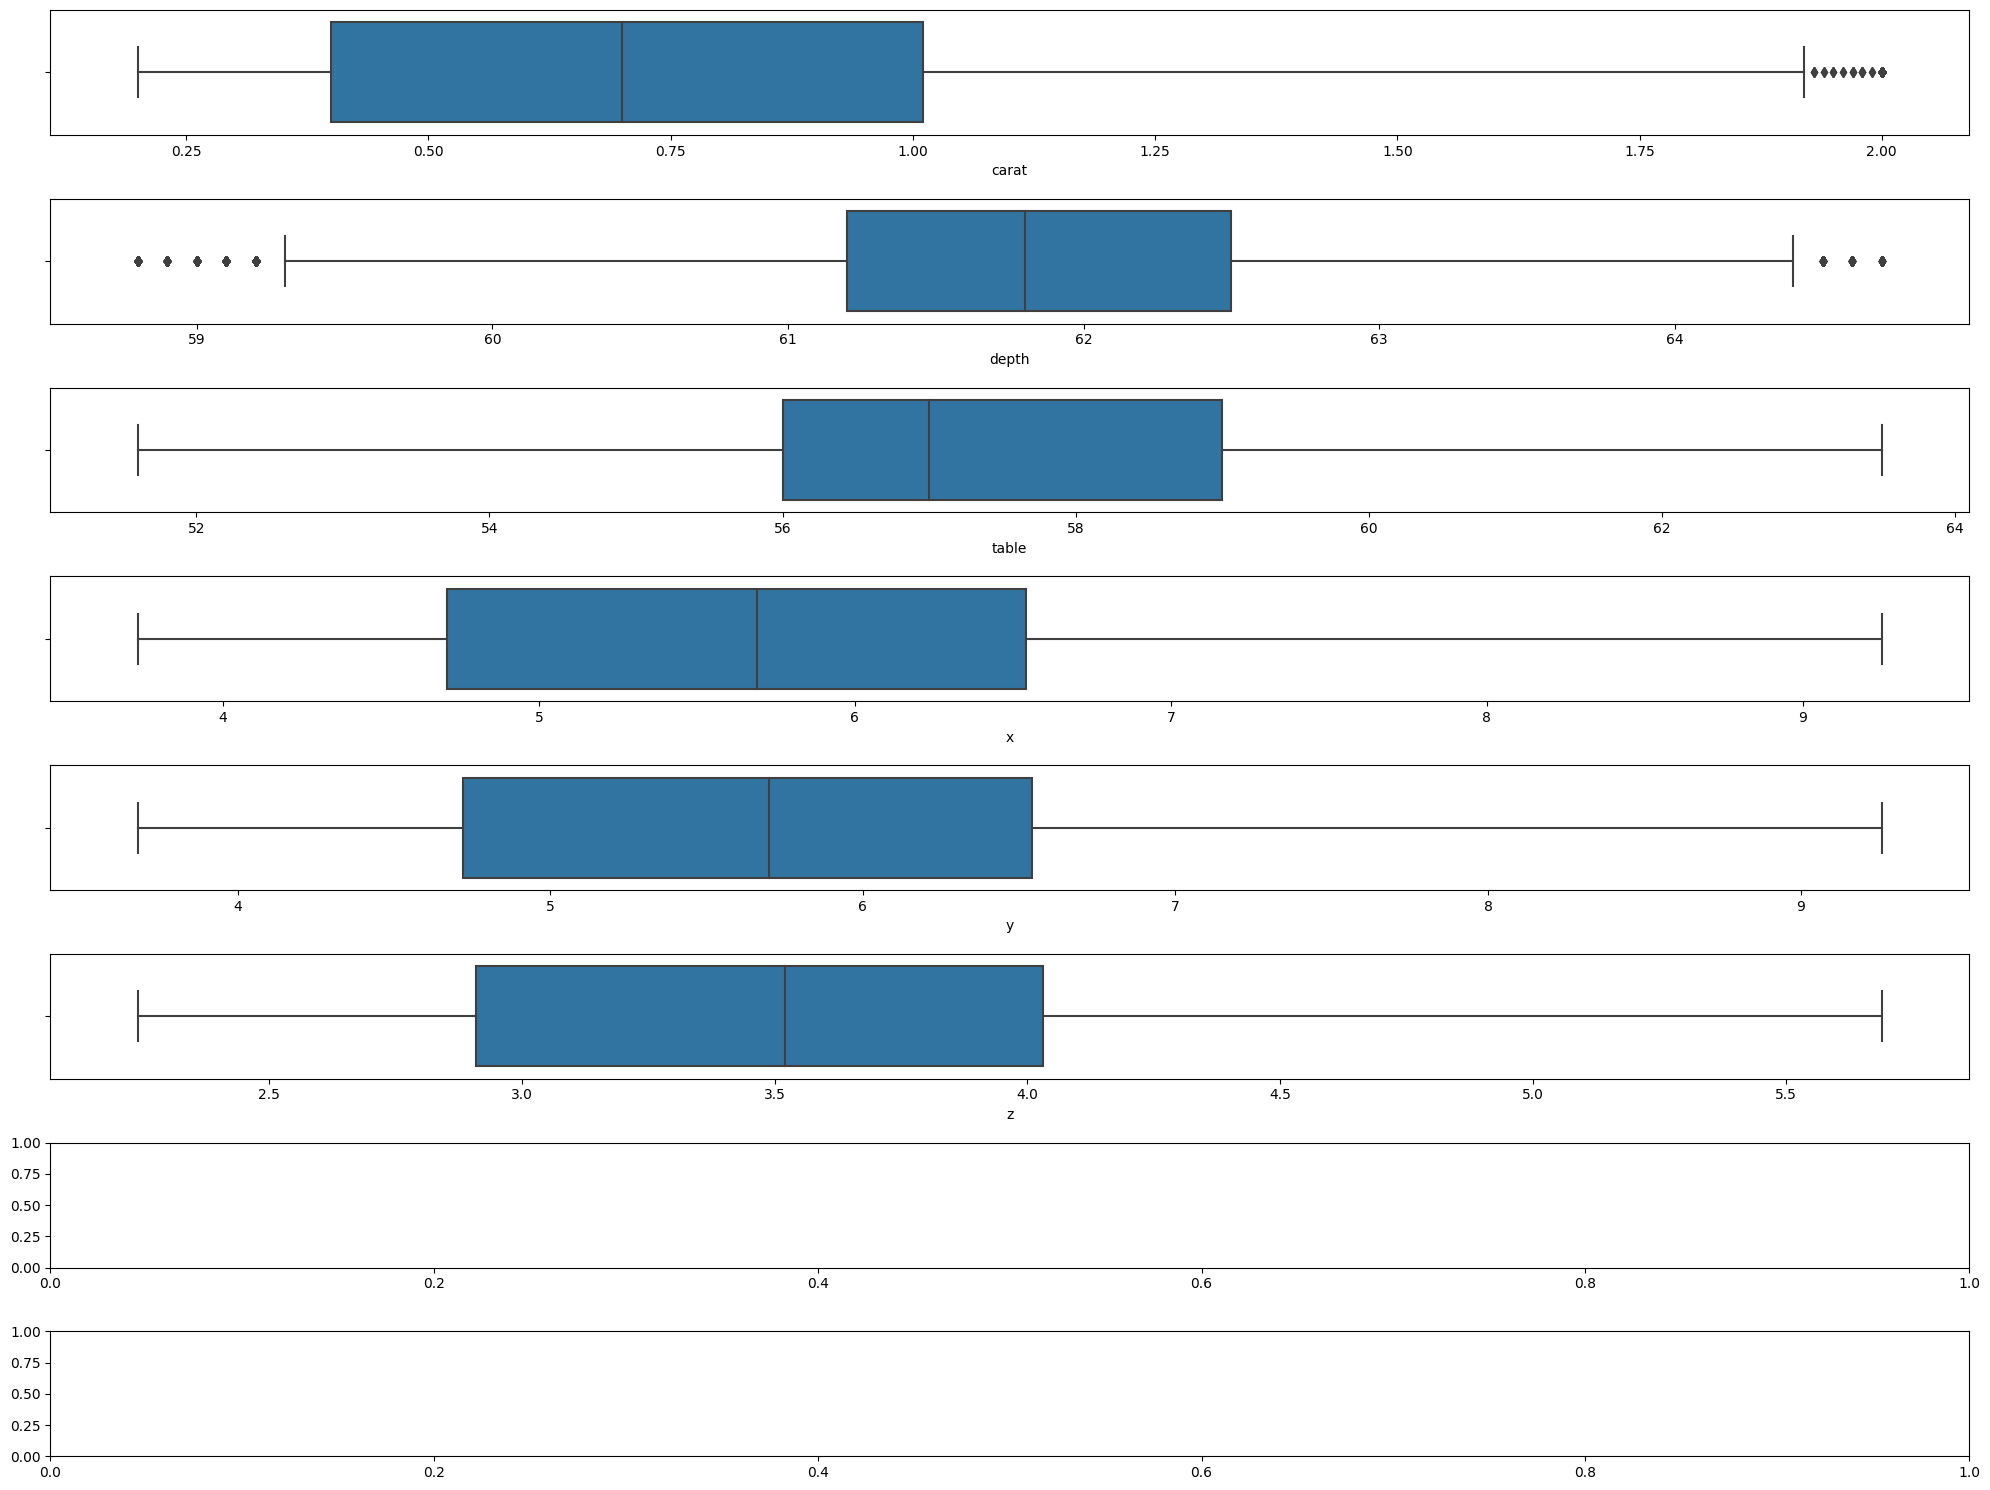

In [11]:
fig, axes = plt.subplots(nrows= 8,ncols= 1, figsize=(20,15))

for i , columna in enumerate(df_num.columns):
    
    sns.boxplot(data = df,
                x = columna,
                ax = axes[i])
    plt.tight_layout()

In [12]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


### ahora viene estandarizar y normalizar
- ya que no tiene outliers, le aplicare un standar scaler
- algunas variables se encodearan con orden y otras sin orden

In [13]:
#STANDARSCALER
# iniciamos el método para escalar
scaler = StandardScaler()
#seleccionamos las variables predictoras numericas
df_sinoutliers_num = df.select_dtypes(include=np.number)
num_col = df_num.columns
# ajustamos nuestros datos
scaler.fit(df[num_col])
#generamos el pickle de esta estandarizacion
with open (f"data/estandarizacion_1.pkl", "wb") as estandarizacion:
    pickle.dump(scaler, estandarizacion)
# transformamos los datos. 
X_escaladas = scaler.transform(df[num_col])
#creamos df nuevo que sera el estandarizado
df_stand = df.copy()
df_stand[num_col] = X_escaladas
df_stand.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,-1.134327,Premium,D,SI2,0.572943,0.306134,-1.266899,-1.304358,-1.241434,6.353
1,0.663241,Ideal,E,VVS2,0.847594,-0.663778,0.617815,0.656199,0.729529,9.183
2,-0.070977,Ideal,F,VS2,0.023640,0.791090,-0.016378,0.008676,0.004910,7.983
3,0.840466,Very Good,G,SI2,1.305347,-0.178822,0.725003,0.692172,0.845468,8.371
4,-0.982419,Premium,G,VS1,0.481392,0.791090,-1.097185,-1.061537,-1.038541,6.588


encoding

In [14]:
# funcion para aplicar el metodo onehotencoder a varibles categoricas SIN ORDEN
#generamos el encoder fuera para poder guardarlo en un pickle, la otra opcion es meter la generacion de pickle en la funcion del soporte
columnas =["cut","color"]
oh = OneHotEncoder()

transformados = oh.fit_transform(df[columnas])

#generamos el pickle de esta estandarizacion
with open (f"data/ohe_cutycolor.pkl", "wb") as normalizacion:
    pickle.dump(oh, normalizacion)

def one_hot_encoder(dff, columnas, oh,transformados):
    
    oh_df = pd.DataFrame(transformados.toarray(), columns = oh.get_feature_names_out(), dtype = int)
    
    dff[oh_df.columns] = oh_df
    
    dff.drop(columnas, axis = 1, inplace = True)
       
    return dff
    

In [15]:
df_encode = one_hot_encoder(df,columnas, oh, transformados)
df_encode.head()

,carat,clarity,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.30,SI2,62.4,58.0,4.31,4.28,2.68,6.353,0,0,0,1,0,1,0,0,0,0,0,0
1,1.01,VVS2,62.7,56.0,6.42,6.46,4.04,9.183,0,0,1,0,0,0,1,0,0,0,0,0
2,0.72,VS2,61.8,59.0,5.71,5.74,3.54,7.983,0,0,1,0,0,0,0,1,0,0,0,0
3,1.08,SI2,63.2,57.0,6.54,6.50,4.12,8.371,0,0,0,0,1,0,0,0,1,0,0,0
4,0.36,VS1,62.3,59.0,4.50,4.55,2.82,6.588,0,0,0,1,0,0,0,0,1,0,0,0


ahora se le hace orodinal_encoder a la variable clarity, que es la unica con orden

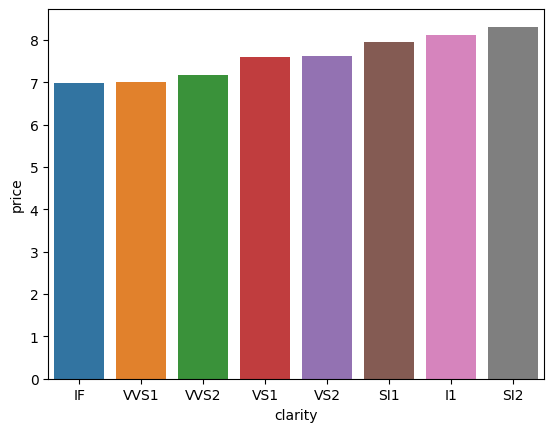

In [16]:
clarity =  df.groupby("clarity")["price"].median().reset_index().sort_values("price", ascending=True)
sns.barplot(data = clarity,
                x = "clarity",
                y= "price");

["IF","VVS1","VVS2","VS1","VS2","SI1","I1","SI2"]

In [17]:
#funcion para aplicar el metodo ordinal encoder para Variables CON ORDEN, 
#de una variable en 1, ya que hay qu aplicarle un orden
# establecemos el orden que queremos, de menos importante a más, en el orden que nosotros queramos darle el valor. 
#para el pickle el ordinal y el fit tienen que estar fiuera
# iniciamos el método y aplicamos la transformación a los datos. 
#OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>, handle_unknown='error', unknown_value=None)

orden_valores = ["IF","VVS1","VVS2","VS1","VS2","SI1","I1","SI2"]

ordinal = OrdinalEncoder(categories = [orden_valores], dtype = int)

transformados_oe = ordinal.fit_transform(df[["clarity"]])
#generamos el pickle de la normalizacion
with open (f"data/oe_clarity.pkl", "wb") as encoder:
    pickle.dump(ordinal, encoder)

def ordinal_encoder1(df, columna, orden_valores,ordinal,transformados_oe):
    
    # lo convertimos a dataframe
    oe_df = pd.DataFrame(transformados_oe)
    # cambiamos el nombre de la columna
    oe_df.columns = ordinal.feature_names_in_
    
    # sobre escribimos la columna con los valores de la tranformación
    df[columna] = oe_df
     
    return df
     

In [18]:
cl = ordinal_encoder1(df_encode,"clarity",orden_valores,ordinal,transformados_oe)
cl.head()

,carat,clarity,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.30,7,62.4,58.0,4.31,4.28,2.68,6.353,0,0,0,1,0,1,0,0,0,0,0,0
1,1.01,2,62.7,56.0,6.42,6.46,4.04,9.183,0,0,1,0,0,0,1,0,0,0,0,0
2,0.72,4,61.8,59.0,5.71,5.74,3.54,7.983,0,0,1,0,0,0,0,1,0,0,0,0
3,1.08,7,63.2,57.0,6.54,6.50,4.12,8.371,0,0,0,0,1,0,0,0,1,0,0,0
4,0.36,3,62.3,59.0,4.50,4.55,2.82,6.588,0,0,0,1,0,0,0,0,1,0,0,0


In [19]:
#ya esta listo el set de datos para aplicar el modelo
train = cl.copy()

In [20]:
train.isnull().sum()

carat            0
clarity          0
depth            0
table            0
x                0
y                0
z                0
price            0
cut_Fair         0
cut_Good         0
cut_Ideal        0
cut_Premium      0
cut_Very Good    0
color_D          0
color_E          0
color_F          0
color_G          0
color_H          0
color_I          0
color_J          0
dtype: int64

In [21]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [22]:

# dividimos el dataset en variables predictoras y respuesta
X= train.drop("price", axis = 1) # variables predictoras
y = train["price"] # variable respuesta

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 666)

decision tree

In [24]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [25]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [26]:
# sacamos las métricas para ver si hay overfitting

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.087946,0.016339,0.127822,0.984252,test,Decission Tree I
1,0.000155,0.000014,0.003792,0.999986,train,Decission Tree I


In [27]:
#generamos el pickle, tiene muy buenas metricas
with open (f"data/dt_new.pkl", "wb") as modelo:
    pickle.dump(regressor, modelo)

ajuste gridsearch

In [28]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4, 5, 6, 7,10,15],
        "min_samples_split": [10, 50, 100],
        "max_features": [1,2,3,4,5,6,7,10]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [31]:
"""# ajustamos el modelo de nuevo

gs.fit(X_train, y_train)"""


'# ajustamos el modelo de nuevo\n\ngs.fit(X_train, y_train)'

In [ ]:
"""# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree"""

In [ ]:
"""# volvamos a intentar visualizar el árbol a ver como se ve: 

fig = plt.figure(figsize=(12, 6))
tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True);"""

In [ ]:
"""#prediccion
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)
"""

hay un error con el gridsearch

In [32]:
# 8. XGB Regressor
xgb = XGBRegressor(learning_rate=0.01, n_estimators=1000, max_depth=5)
xgb.fit(X_train, y_train)
#prediccion
y_pred_test_xgb= xgb.predict(X_test)
y_pred_train_xgb = xgb.predict(X_train)



In [34]:
xgb_results = metricas(y_test, y_train, y_pred_test_xgb, y_pred_train_xgb, " XGB Regressor")
xgb_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.073569,0.009747,0.098727,0.990605,test,XGB Regressor
1,0.071186,0.008931,0.094504,0.991354,train,XGB Regressor


In [40]:
#generamos el pickle, tiene muy buenas metricas
with open (f"data/xgb_new.pkl", "wb") as modelo:
    pickle.dump(xgb, modelo)

In [35]:
# 12. Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200)
gb.fit(X_train, y_train)
#prediccion
y_pred_test_gb= gb.predict(X_test)
y_pred_train_gb = gb.predict(X_train)


In [36]:
gb_results = metricas(y_test, y_train, y_pred_test_gb, y_pred_train_gb, " GradientBoosting regressor")
gb_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.076933,0.010721,0.103544,0.989666,test,GradientBoosting regressor
1,0.075452,0.010477,0.102359,0.989857,train,GradientBoosting regressor


In [41]:
#generamos el pickle, tiene muy buenas metricas
with open (f"data/gb_new.pkl", "wb") as modelo:
    pickle.dump(gb, modelo)

RandomForest

In [37]:
param = {"max_depth": [ 6, 7,8,9,10],#desppues de sacar el besttree estimator se ajustan estor hiperparametros
        "min_samples_split": [10, 15,20],
        "max_features": [3,4,5,6],
         'min_samples_leaf': [10,15,20,40,50]}# aqui despues de ver el best estimator, se ajustan y se quitan hiperparametros.

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [ ]:
"""bosque.fit(X_train, y_train)"""

In [39]:
all = pd.concat([dt_results1,xgb_results,gb_results])
all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087946,0.016339,0.127822,0.984252,test,Decission Tree I
1,0.000155,0.000014,0.003792,0.999986,train,Decission Tree I
0,0.073569,0.009747,0.098727,0.990605,test,XGB Regressor
1,0.071186,0.008931,0.094504,0.991354,train,XGB Regressor
0,0.076933,0.010721,0.103544,0.989666,test,GradientBoosting regressor
1,0.075452,0.010477,0.102359,0.989857,train,GradientBoosting regressor


estas 3 son mejores que todas las otras hechas anteriormente

# limpiamos el test

In [48]:
train.head()

,carat,clarity,depth,table,x,y,z,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.30,7,62.4,58.0,4.31,4.28,2.68,6.353,0,0,0,1,0,1,0,0,0,0,0,0
1,1.01,2,62.7,56.0,6.42,6.46,4.04,9.183,0,0,1,0,0,0,1,0,0,0,0,0
2,0.72,4,61.8,59.0,5.71,5.74,3.54,7.983,0,0,1,0,0,0,0,1,0,0,0,0
3,1.08,7,63.2,57.0,6.54,6.50,4.12,8.371,0,0,0,0,1,0,0,0,1,0,0,0
4,0.36,3,62.3,59.0,4.50,4.55,2.82,6.588,0,0,0,1,0,0,0,0,1,0,0,0


In [67]:
test = pd.read_csv("data/test.csv")
test.drop("id", axis= 1, inplace = True)
test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70
1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26
2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70
3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59
4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67


In [68]:
#llamamos al pickle para estandarizar
# estandarizacion
with open('data/estandarizacion_1.pkl', 'rb') as estandar:
    estandar = pickle.load(estandar)

In [69]:
test_estand = pd.DataFrame(estandar.transform(test[['carat', 'depth', 'table', 'x', 'y', 'z']]), columns = ['carat', 'depth', 'table', 'x', 'y', 'z'])
test_estand.head()

,carat,depth,table,x,y,z
0,-1.083691,-1.166517,0.306134,-1.159711,-1.115497,-1.212450
1,1.245551,1.030695,1.276047,0.957242,0.908013,1.048361
2,2.308901,0.206741,0.791090,1.627164,1.681444,1.686026
3,0.004977,-1.074966,-0.663778,0.189065,0.152570,0.077372
4,1.903815,2.770155,-1.148734,1.368128,1.276742,1.642548


In [75]:
test_estand.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [53]:
#encoding
with open('data/ohe_cutycolor.pkl', 'rb') as encode:
    encode = pickle.load(encode)


In [ ]:
"""test_encode_1 = pd.DataFrame(encode.transform(test[['cut', "color"]]), columns =['cut','color'])
test_encode_1.head()"""
#me sale error

In [70]:
def one_hot_encoder(dff, columnas, oh,transformados):
    
    oh_df = pd.DataFrame(transformados.toarray(), columns = oh.get_feature_names_out(), dtype = int)
    
    dff[oh_df.columns] = oh_df
    
    dff.drop(columnas, axis = 1, inplace = True)
       
    return dff
    

In [71]:
columnas =["cut","color"]
transformados = oh.fit_transform(test[columnas])
#no hace falta llamar al pickle, oh esta un poco mas arriba y no la generamos de nuevo
df_encode = one_hot_encoder(test,columnas, oh, transformados)
df_encode.head()

,carat,clarity,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.32,SI1,60.5,58.0,4.43,4.49,2.70,0,0,1,0,0,0,0,0,0,0,1,0
1,1.24,SI1,62.9,60.0,6.80,6.74,4.26,0,0,0,1,0,0,0,0,0,0,1,0
2,1.66,SI1,62.0,59.0,7.55,7.60,4.70,0,0,0,1,0,1,0,0,0,0,0,0
3,0.75,SI2,60.6,56.0,5.94,5.90,3.59,0,0,0,1,0,1,0,0,0,0,0,0
4,1.50,SI2,64.8,55.0,7.26,7.15,4.67,1,0,0,0,0,0,1,0,0,0,0,0


queda la variable clarity

In [72]:
# encoding
with open('data/oe_clarity.pkl', 'rb') as encoding:
    encoding = pickle.load(encoding)

In [74]:
df_clarity = pd.DataFrame(encoding.transform(df_encode[['clarity']]), columns =['clarity'])
df_clarity.head()

,clarity
0,5
1,5
2,5
3,7
4,7


In [77]:
df_encode[['carat', 'depth', 'table', 'x', 'y', 'z']] = test_estand[['carat', 'depth', 'table', 'x', 'y', 'z']]

In [79]:
df_encode["clarity"] = df_clarity["clarity"]

In [80]:
df_encode.head()

,carat,clarity,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,-1.083691,5,-1.166517,0.306134,-1.159711,-1.115497,-1.212450,0,0,1,0,0,0,0,0,0,0,1,0
1,1.245551,5,1.030695,1.276047,0.957242,0.908013,1.048361,0,0,0,1,0,0,0,0,0,0,1,0
2,2.308901,5,0.206741,0.791090,1.627164,1.681444,1.686026,0,0,0,1,0,1,0,0,0,0,0,0
3,0.004977,7,-1.074966,-0.663778,0.189065,0.152570,0.077372,0,0,0,1,0,1,0,0,0,0,0,0
4,1.903815,7,2.770155,-1.148734,1.368128,1.276742,1.642548,1,0,0,0,0,0,1,0,0,0,0,0


In [81]:
test_final = df_encode.copy()

## modelos predictivos

In [82]:
all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087946,0.016339,0.127822,0.984252,test,Decission Tree I
1,0.000155,0.000014,0.003792,0.999986,train,Decission Tree I
0,0.073569,0.009747,0.098727,0.990605,test,XGB Regressor
1,0.071186,0.008931,0.094504,0.991354,train,XGB Regressor
0,0.076933,0.010721,0.103544,0.989666,test,GradientBoosting regressor
1,0.075452,0.010477,0.102359,0.989857,train,GradientBoosting regressor


In [83]:
# cargamos el mejor modelo
with open('data/dt_new.pkl', 'rb') as modelo:
    modelo = pickle.load(modelo)

In [84]:
resultado1 = pd.DataFrame(modelo.predict(test_final), columns = ["price"]).reset_index()
resultado1.rename(columns = {"index": "id"}, inplace = True)
resultado1.head()

,id,price
0,0,5.844
1,1,7.522
2,2,7.646
3,3,5.844
4,4,7.741


In [85]:
resultado1.to_csv("data/modelo_dt.csv", index = False)

In [86]:
# cargamos el mejor modelo
with open('data/xgb_new.pkl', 'rb') as modelo:
    modelo = pickle.load(modelo)

In [87]:
resultado1 = pd.DataFrame(modelo.predict(test_final), columns = ["price"]).reset_index()
resultado1.rename(columns = {"index": "id"}, inplace = True)
resultado1.head()

,id,price
0,0,5.755067
1,1,6.919140
2,2,7.329895
3,3,5.870778
4,4,7.157929


In [88]:
resultado1.to_csv("data/modelo_xgb.csv", index = False)

In [89]:
# cargamos el mejor modelo
with open('data/gb_new.pkl', 'rb') as modelo:
    modelo = pickle.load(modelo)

In [90]:
resultado1 = pd.DataFrame(modelo.predict(test_final), columns = ["price"]).reset_index()
resultado1.rename(columns = {"index": "id"}, inplace = True)
resultado1.head()

,id,price
0,0,5.664171
1,1,7.006260
2,2,7.608654
3,3,5.756040
4,4,7.700231


In [91]:
resultado1.to_csv("data/modelo_gb.csv", index = False)